In [2]:
from torch.optim import lr_scheduler
from torch.optim import SGD


from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

In [2]:
_ = [print(o) for o in dir(lr_scheduler) if o[0].isupper()]

ChainedScheduler
ConstantLR
CosineAnnealingLR
CosineAnnealingWarmRestarts
Counter
CyclicLR
EPOCH_DEPRECATION_WARNING
ExponentialLR
LRScheduler
LambdaLR
LinearLR
MultiStepLR
MultiplicativeLR
OneCycleLR
Optimizer
PolynomialLR
ReduceLROnPlateau
SequentialLR
StepLR


/home/admin/anaconda3/envs/samwell/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


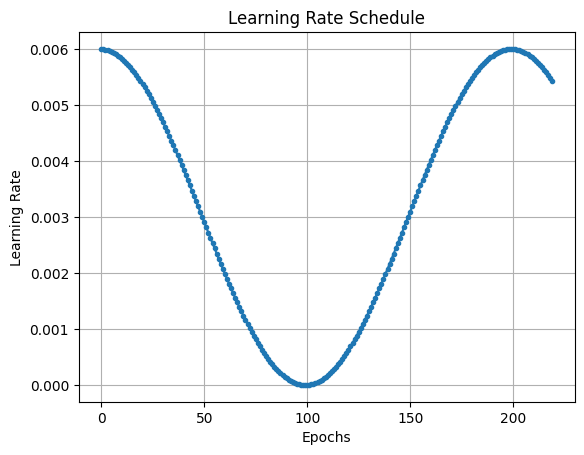

In [3]:
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Define your LR scheduler
optimizer = torch.optim.SGD([torch.tensor([1.0])], lr=6e-3)  # Dummy optimizer
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)  # Example StepLR scheduler

# Lists to store LR values and epochs
lr_values = []
epochs = []

# Training loop
for epoch in range(220):
    # Update the LR at the end of each epoch
    scheduler.step()
    
    # Record the current LR and epoch
    current_lr = optimizer.param_groups[0]['lr']  # Get the last LR value
    lr_values.append(current_lr)
    epochs.append(epoch)

# Plot the LR schedule
plt.plot(epochs, lr_values, marker='.')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()

In [3]:
from datasets import load_dataset,load_dataset_builder
import torch
import torchvision.transforms.functional as TF
from miniai.datasets import *

x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)


bs = 256
@inplace
def transformi(b): b['image'] = [(torch.flatten(TF.to_tensor(o)).view(-1, 28, 28) - 0.29) / 0.35 for o in b['image']]

tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

x_mean = xb.mean((1,2,3), keepdim=True)
x_std = xb.std((1,2,3), keepdim=True)

Found cached dataset fashion_mnist (/home/admin/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
len(dt)

235

In [5]:
from torch import nn
import torch.nn.functional as F
import torch
import numpy as np
from miniai.init import GeneralRelu

In [9]:
from miniai.activations import ActivationStats, MetricsCB, DeviceCB, ProgressCB
import fastcore.all as fc
from torcheval.metrics import MulticlassAccuracy
from miniai.learner import TrainLearner as Learner
from miniai.sgd import get_model, conv

metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(nn.BatchNorm2d))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), visual]
model = get_model(act=GeneralRelu, norm=nn.BatchNorm2d)
learn = Learner(model, dls, F.cross_entropy, lr=0.2,cbs=cbs)
learn.fit(3)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()

In [8]:
# def get_model(act=nn.ReLU, nfs=None, norm=None):
#     if nfs is None: nfs = [1,8,16,32,64]
#     layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
#     return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
#                          nn.Flatten())

In [7]:
from miniai.activations import Callback
from torch.optim.lr_scheduler import CosineAnnealingLR

class BaseSchedulerCB(Callback):
    def __init__(self, sched):
        self.sched = sched
    def before_fit(self, learn):
        self.schedo = self.sched(learn.opt)
        
    def step(self, learn):
        if learn.training: self.schedo.step()
            
class BatchSchedulerCB(BaseSchedulerCB):
    def after_batch(self, learn): self.step(learn)

class EpochSchedulerCB(BaseSchedulerCB):
    def after_epoch(self, learn): self.step(learn)

        
class StatisticCB(Callback):
    def __init__(self, **fs):
        self.stats = [[] for f in fs]
        self.fs = fs

    def after_batch(self, learn):
        for i, f in enumerate(self.fs):
            self.stats[i].append(self.fs[f](learn.opt.param_groups[0]))
        
    def plot(self):
        for name, y in zip(self.fs, self.stats):
            plt.plot(y, marker='o', linestyle='-')
            plt.xlabel('epoch')
            plt.ylabel('name')
            plt.title('name')
            plt.show()
    
def _lr(param_groups): return param_groups['lr']
def _mom(param_groups): return param_groups['betas'][0]

accuracy,loss,epoch,train
0.803,0.555,0,train
0.822,0.477,0,eval
0.866,0.371,1,train
0.857,0.393,1,eval
0.880,0.337,2,train
0.862,0.379,2,eval


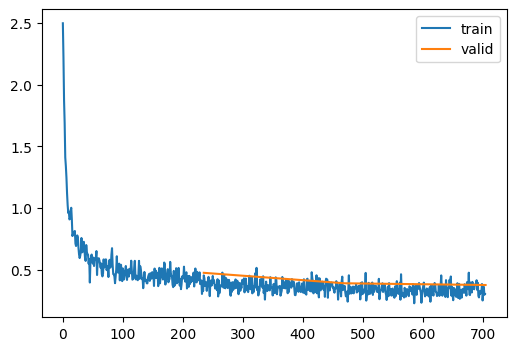

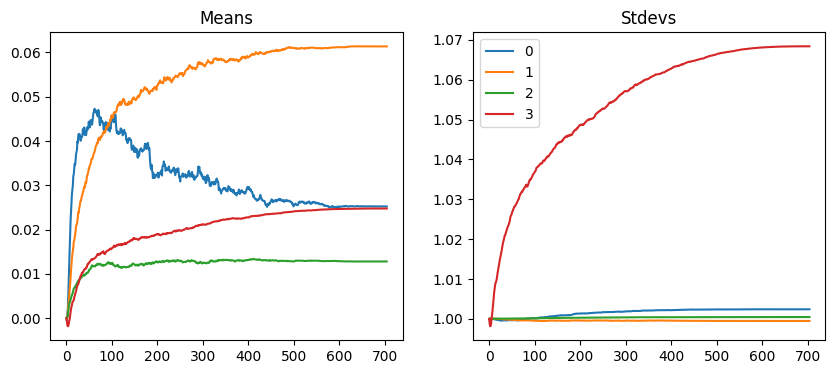

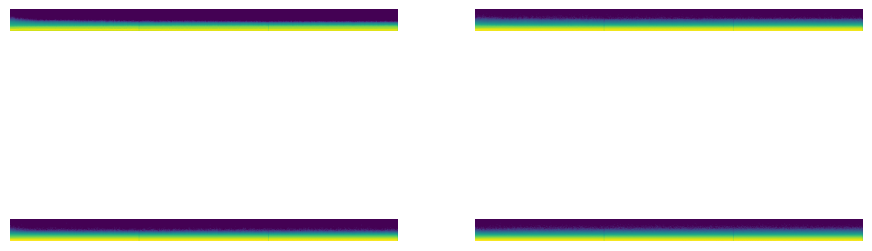

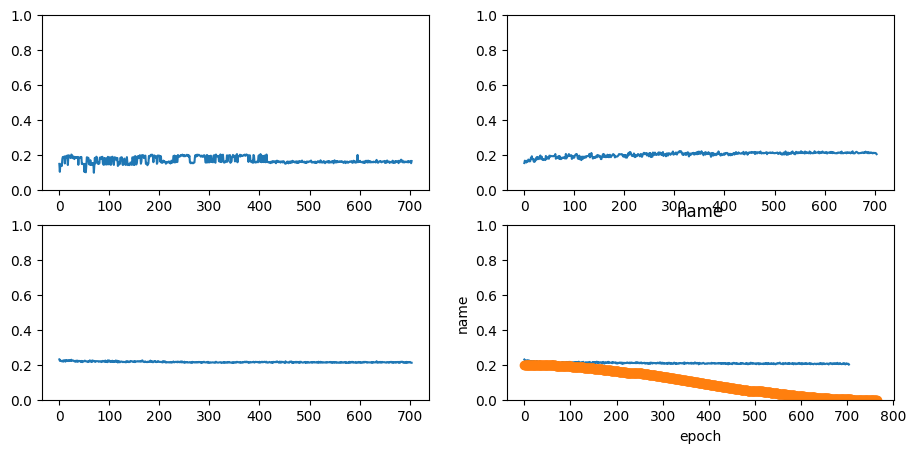

In [51]:
from miniai.activations import ActivationStats, MetricsCB, DeviceCB, ProgressCB
from miniai.init import init_weights 
import fastcore.all as fc
from torcheval.metrics import MulticlassAccuracy
from miniai.learner import TrainLearner as Learner
from functools import partial


metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(nn.BatchNorm2d))
stats = StatisticCB(lr = _lr)
cbs = [stats, DeviceCB(), metrics, ProgressCB(plot=True), visual, BatchSchedulerCB(partial(CosineAnnealingLR, T_max=len(dt) * 3))]
model = get_model(act=nn.LeakyReLU , norm=nn.BatchNorm2d).apply(partial(init_weights, leaky=0.01))
learn = Learner(model, dls, F.cross_entropy, lr=0.2,cbs=cbs)
learn.fit(3)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()
stats.plot()

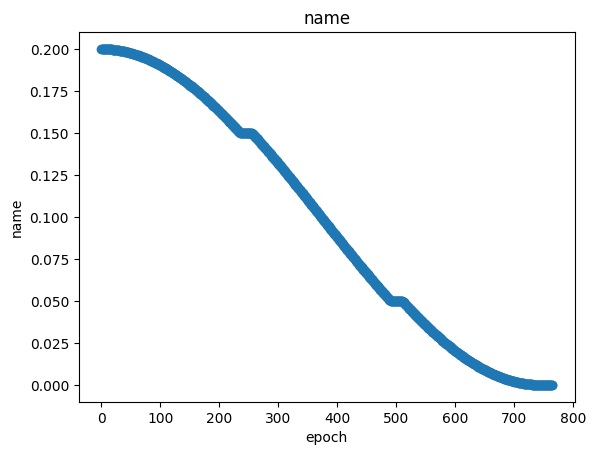

In [52]:
stats.plot()

accuracy,loss,epoch,train
0.812,0.521,0,train
0.835,0.474,0,eval
0.867,0.361,1,train
0.848,0.409,1,eval
0.888,0.301,2,train
0.892,0.299,2,eval
0.909,0.243,3,train
0.900,0.267,3,eval
0.930,0.190,4,train
0.909,0.251,4,eval


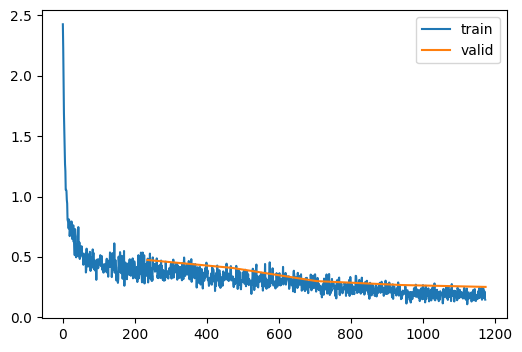

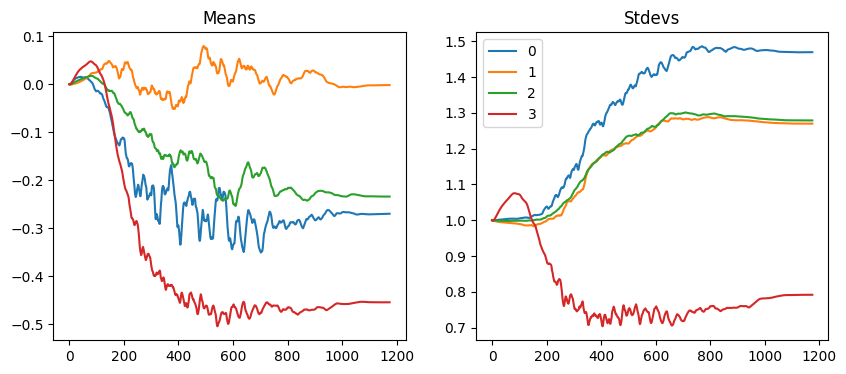

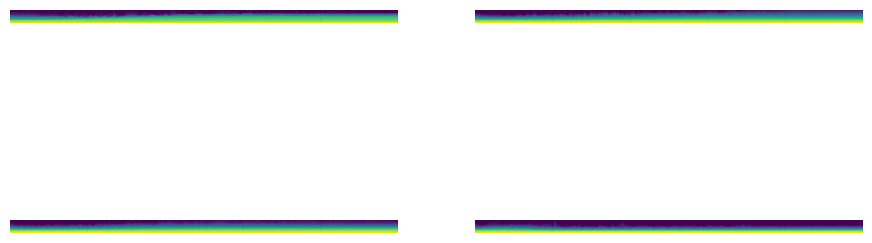

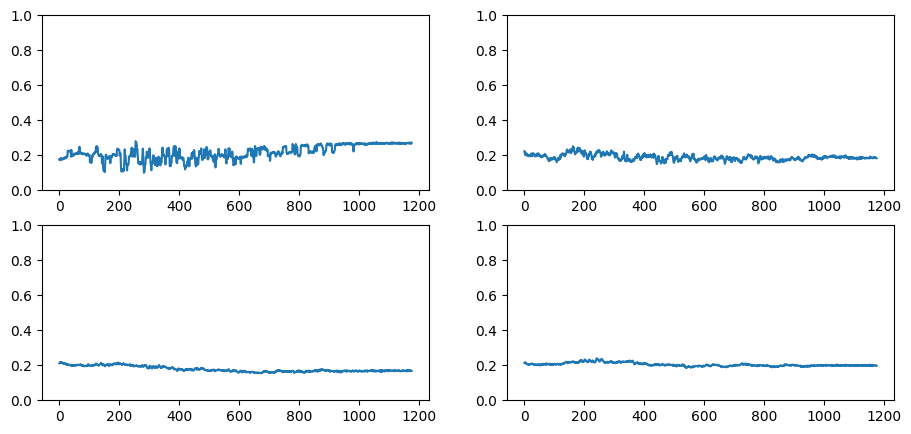

In [64]:
from miniai.activations import ActivationStats, MetricsCB, DeviceCB, ProgressCB
from miniai.init import init_weights 
import fastcore.all as fc
from torcheval.metrics import MulticlassAccuracy
from miniai.learner import TrainLearner as Learner
from functools import partial


max_lr = 6e-2  # Maximum learning rate
total_batchs = 5 * len(dt) # Total number of training epochs
pct_start = 0.3  # Percentage of epochs for increasing the learning rate
scheduler = partial(OneCycleLR, max_lr=max_lr, total_steps=total_batchs, pct_start=pct_start)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(nn.BatchNorm2d))
stats = StatisticCB(lr=_lr, momentum=_mom)


cbs = [stats, DeviceCB(), metrics, ProgressCB(plot=True), visual, BatchSchedulerCB(scheduler)]
model = get_model(act=nn.LeakyReLU , norm=nn.BatchNorm2d).apply(partial(init_weights, leaky=0.01))
learn = Learner(model, dls, F.cross_entropy, lr=6e-2,cbs=cbs, opt_func=torch.optim.AdamW)
learn.fit(5)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()

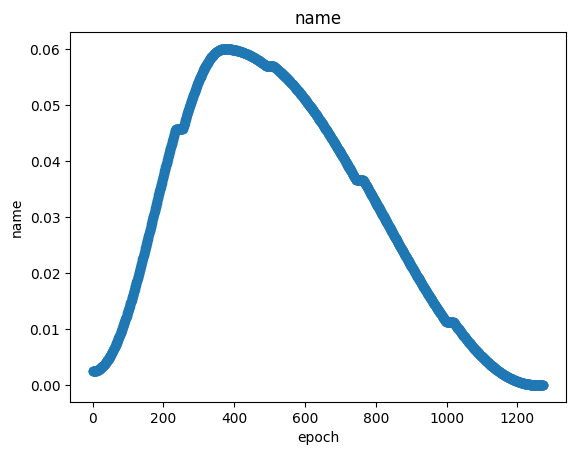

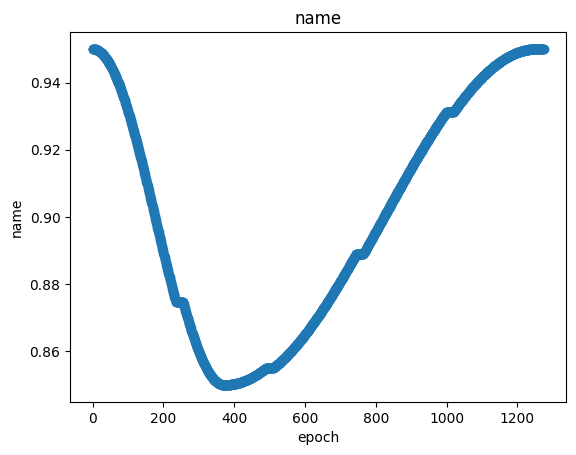

In [65]:
stats.plot()

In [17]:
from miniai.conv import def_device

def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [8,16,32,64,128]
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.838,0.448,0,train
0.860,0.416,0,eval
0.881,0.327,1,train
0.877,0.352,1,eval
0.902,0.265,2,train
0.891,0.309,2,eval
0.925,0.200,3,train
0.916,0.230,3,eval
0.947,0.141,4,train
0.922,0.218,4,eval


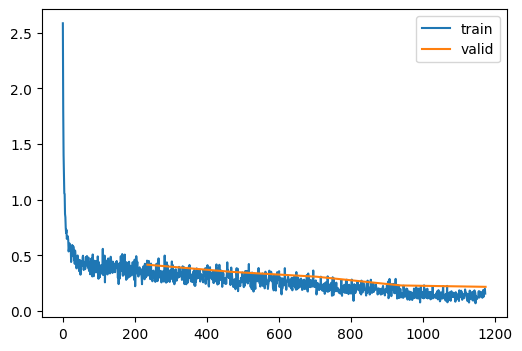

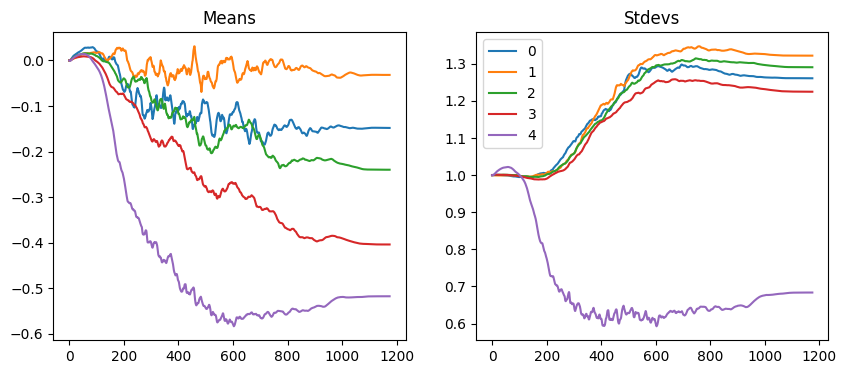

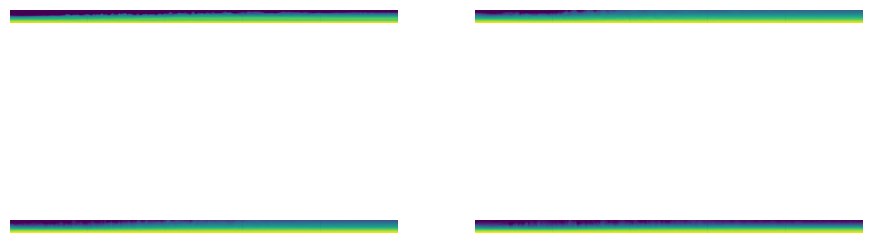

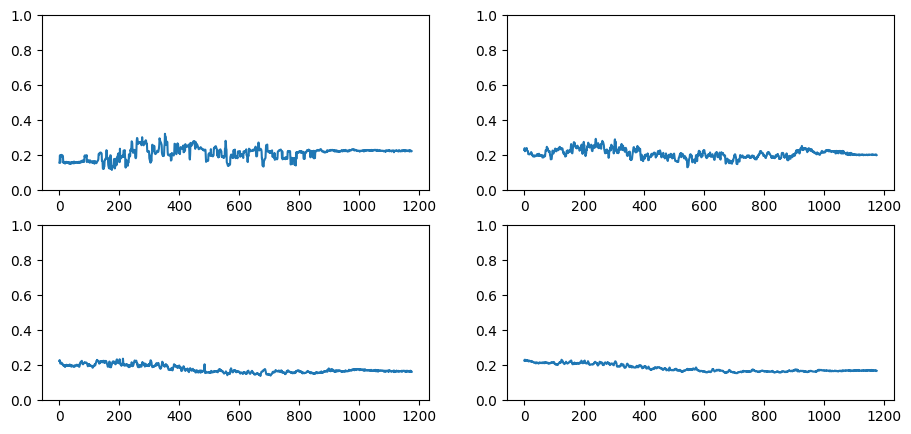

In [18]:
from miniai.activations import ActivationStats, MetricsCB, DeviceCB, ProgressCB
from miniai.init import init_weights 
import fastcore.all as fc
from torcheval.metrics import MulticlassAccuracy
from miniai.learner import TrainLearner as Learner
from functools import partial


max_lr = 6e-2  # Maximum learning rate
total_batchs = 5 * len(dt) # Total number of training epochs
pct_start = 0.3  # Percentage of epochs for increasing the learning rate
scheduler = partial(OneCycleLR, max_lr=max_lr, total_steps=total_batchs, pct_start=pct_start)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
visual = ActivationStats(mod_filter=fc.risinstance(nn.BatchNorm2d))
stats = StatisticCB(lr=_lr, momentum=_mom)


cbs = [stats, DeviceCB(), metrics, ProgressCB(plot=True), visual, BatchSchedulerCB(scheduler)]
model = get_model(act=nn.LeakyReLU , norm=nn.BatchNorm2d).apply(partial(init_weights, leaky=0.01))
learn = Learner(model, dls, F.cross_entropy, lr=6e-2,cbs=cbs, opt_func=torch.optim.AdamW)
learn.fit(5)
visual.plot_stats()
visual.color_dim()
visual.dead_chart()